# Binary Classification ML Model

# Import Libraries

Download the necessary libraries

In [12]:
# Data Manipulation and Visualization Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Odds Ratios and Variance Inflation Factors
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data preprocessing and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score

# ML models that will be used
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Used for hyperparameter tuning for XGBoost
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

# Used for feature importance for KNN
from sklearn.inspection import permutation_importance


In [2]:
# So that we can see all of the columns when working with the data frames (not necessary for this small dataset)
pd.set_option('display.max_columns', None)

## Load Dataset
This data set can be downloaded from Kaggle and moved to the same folder as the jupyter notebook you are working on

In [3]:
df = pd.read_csv("heart.csv")

## About the Data
- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

In [4]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [10]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


## Value Counts for Categorical Data

In [583]:
for col in df.columns:
    if df[col].dtype == 'object':
        print(df[col].value_counts(dropna=False))
        print()

Sex
M    725
F    193
Name: count, dtype: int64

ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: count, dtype: int64

RestingECG
Normal    552
LVH       188
ST        178
Name: count, dtype: int64

ExerciseAngina
N    547
Y    371
Name: count, dtype: int64

ST_Slope
Flat    460
Up      395
Down     63
Name: count, dtype: int64



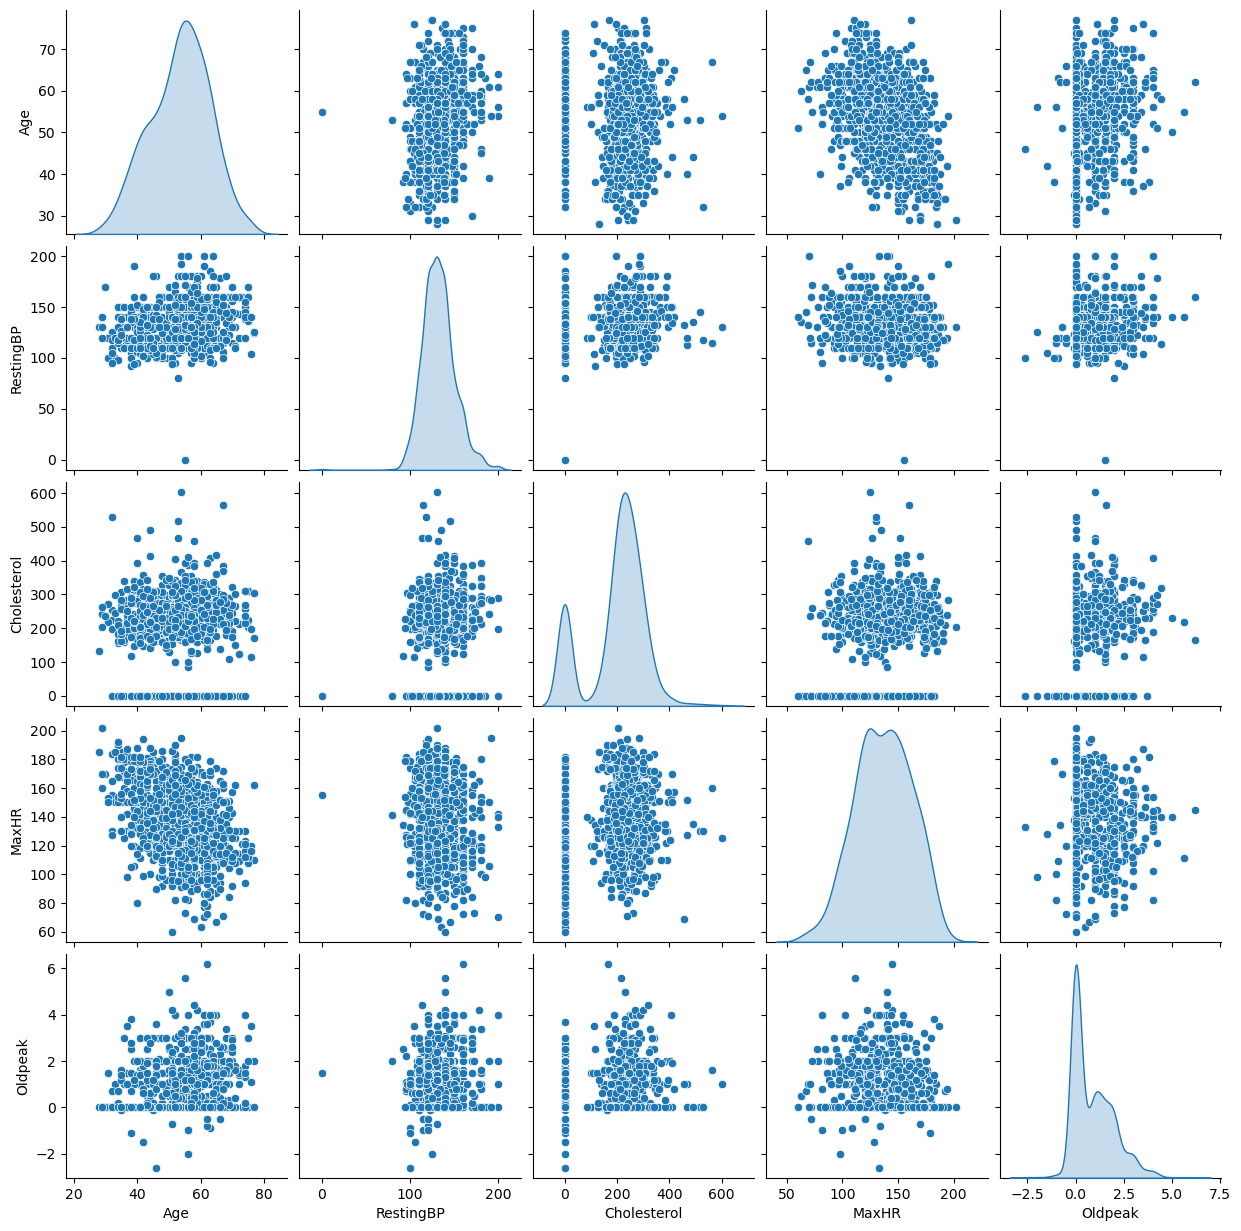

In [60]:
sns.pairplot(df.drop(['HeartDisease', 'FastingBS'], axis=1), diag_kind='kde')

In [84]:
# 18% of our cholesterol has zero values. I left them alone for now, but I'm wondering if these data were filled when the dataset was made, and should rather be imputed (via median, logistic regression, or KNN Imputation)
len(df[df['Cholesterol']==0])/len(df)

0.18736383442265794

## Multicolinearity
Steps:
- Compute a correlation matrix (visualized by a heatmap) and flag variables with an absolute correlation of greater than 0.7 for further investigation.
- Calculate the Variance Inflation Factor (VIF), flagging features with VIF of greater than 5.
- Compute the condition number with a value of greater than 30 indicating multicollinearity.

Text(0.5, 1.0, 'Numeric Feature Correlation Map')

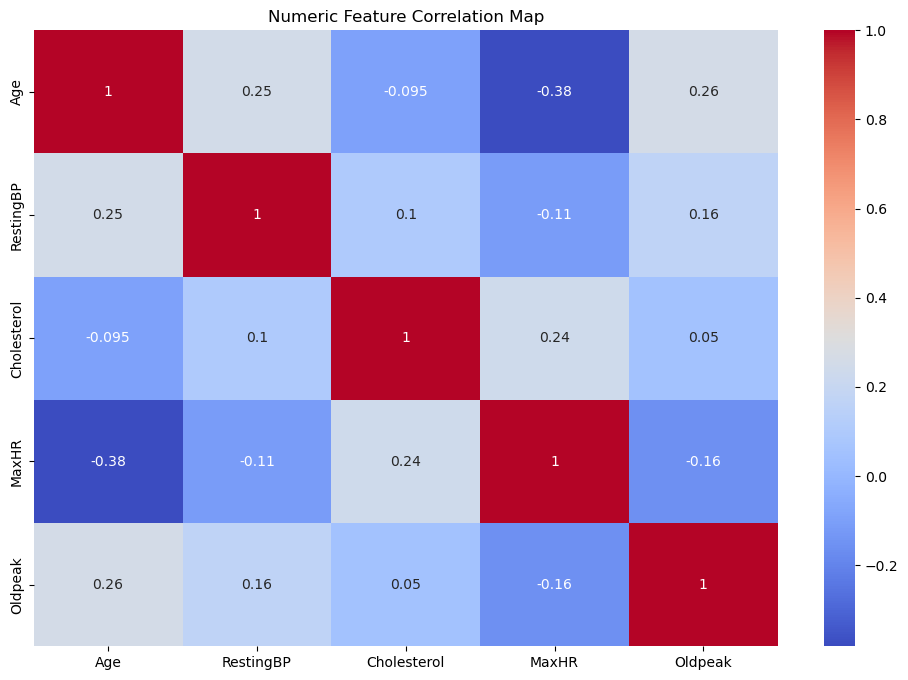

In [73]:
plt.figure(figsize=(12,8))
sns.heatmap(df.drop(['HeartDisease', 'FastingBS'], axis=1).corr(numeric_only=True), cmap='coolwarm', annot=True, cbar=True)
plt.title("Numeric Feature Correlation Map")

There are no two variables with an absolute correlation greater than 0.7

In [78]:
cat_cols = []
for col in df.columns:
    if df[col].dtype=='O':
        cat_cols.append(col)

In [ ]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first').set_output(transform='pandas')
vif_data = ohe.fit_transform(df[cat_cols])


In [82]:
ohe.fit_transform(df[cat_cols])

,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
913,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
914,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
915,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
916,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Additional Data Visualization and Exploration

<Axes: xlabel='Age', ylabel='Count'>

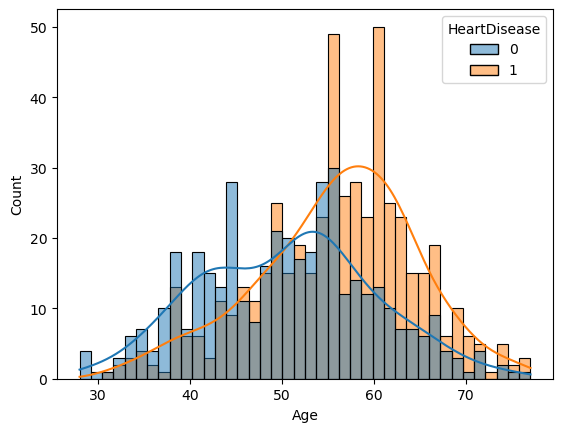

In [27]:
sns.histplot(data=df, x='Age', bins=40, kde=True, hue='HeartDisease')

<Axes: xlabel='Sex', ylabel='count'>

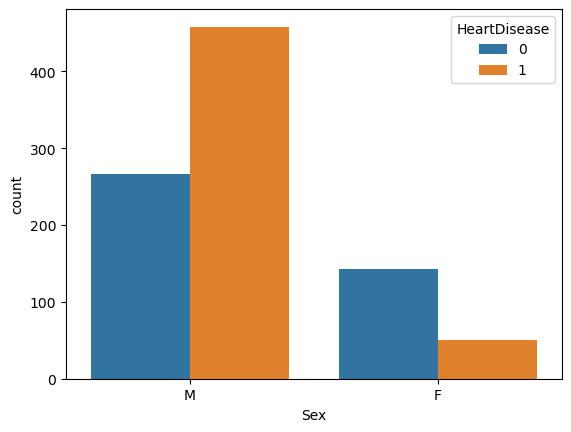

In [28]:
sns.countplot(df, x='Sex', hue='HeartDisease')


<Axes: xlabel='ChestPainType', ylabel='count'>

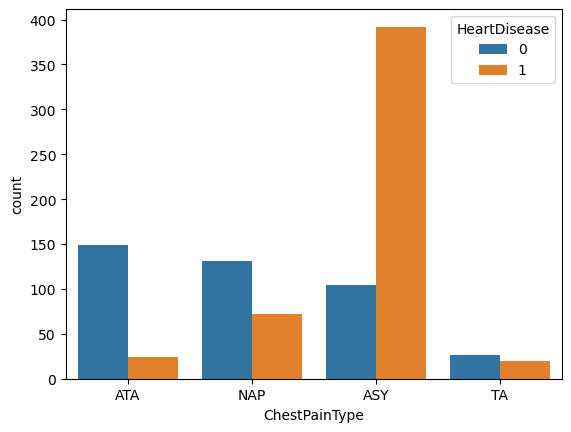

In [29]:
sns.countplot(data=df, x=df['ChestPainType'], hue='HeartDisease')

<Axes: xlabel='RestingBP', ylabel='Count'>

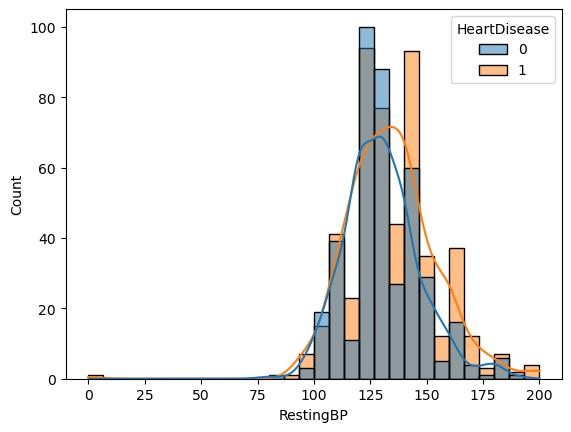

In [30]:
sns.histplot(data=df, x='RestingBP', bins=30, kde=True, hue='HeartDisease')

<Axes: xlabel='Cholesterol', ylabel='Count'>

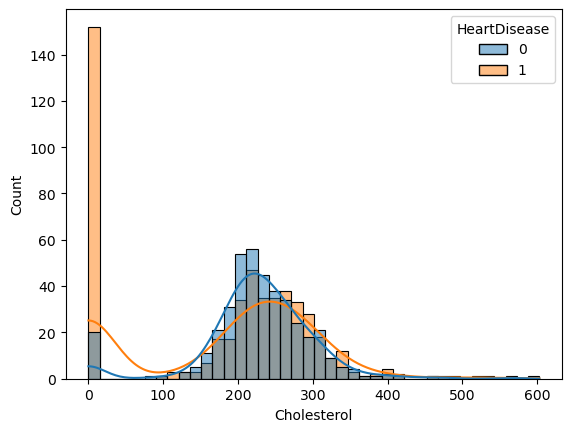

In [31]:
sns.histplot(data=df, x='Cholesterol', bins=40, kde=True, hue='HeartDisease')

In [32]:
df[df['Cholesterol'] == 0]['HeartDisease'].value_counts()

HeartDisease
1    152
0     20
Name: count, dtype: int64

What's happening here with a Cholesterol of 0?

<Axes: xlabel='FastingBS', ylabel='count'>

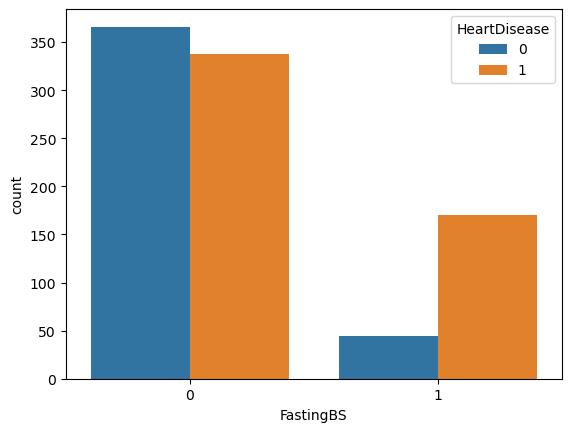

In [33]:
sns.countplot(data=df, x='FastingBS', hue='HeartDisease')

<Axes: xlabel='RestingECG', ylabel='count'>

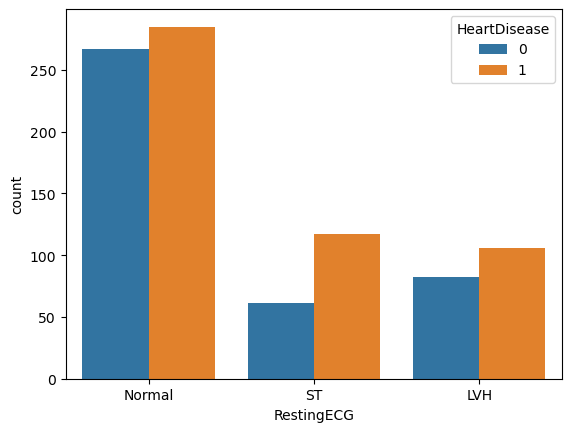

In [34]:
sns.countplot(data=df, x='RestingECG', hue='HeartDisease')

### Common Causes of ST Segment Elevation
- Acute myocardial infarction
- Coronary vasospasm (Printzmetal’s angina)
- Pericarditis
- Benign early repolarization
- Left bundle branch block
- Left ventricular hypertrophy
- Ventricular aneurysm
- Brugada syndrome
- Ventricular paced rhythm
- Raised intracranial pressure
- Takotsubo Cardiomyopathy

### Most Common Causes of LVH (Left Ventricular Hypertrophy)
- Aortic Stenosis
- Aortic Regurgitation
- Hypertension
- Cardiomyopathy
- Coarctation of the Aorta

This was just a quick search, but if LVH can be a cause of Elevation in the ST segment, couldn't our data be skewed or there is undocumented overlap?

<Axes: xlabel='MaxHR', ylabel='Count'>

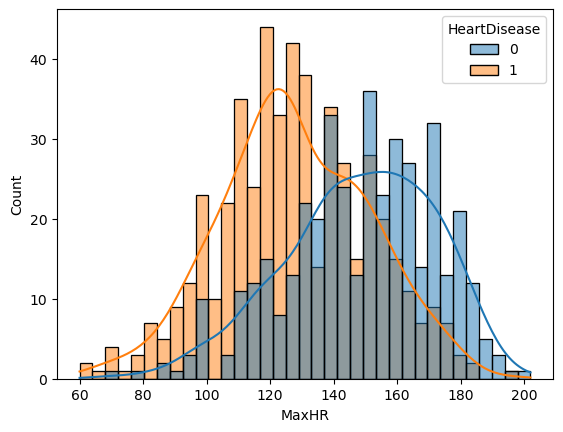

In [35]:
sns.histplot(data=df, x='MaxHR', bins=35, kde=True, hue='HeartDisease')

<Axes: xlabel='ExerciseAngina', ylabel='count'>

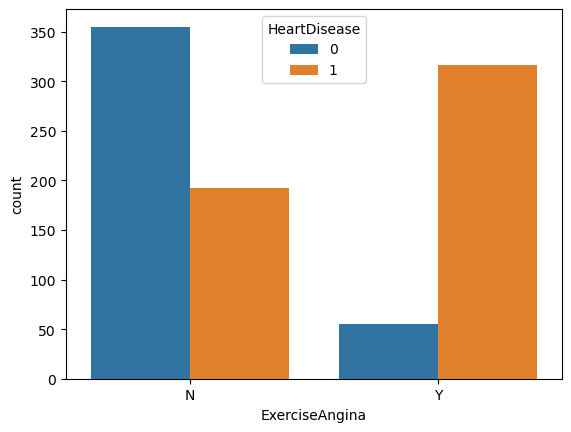

In [36]:
sns.countplot(data=df, x=df['ExerciseAngina'], hue='HeartDisease')

Angina: A type of chest pain caused by reduced blood flow to the heart. Angina is a symptom of coronary artery disease.

<Axes: xlabel='Oldpeak', ylabel='Count'>

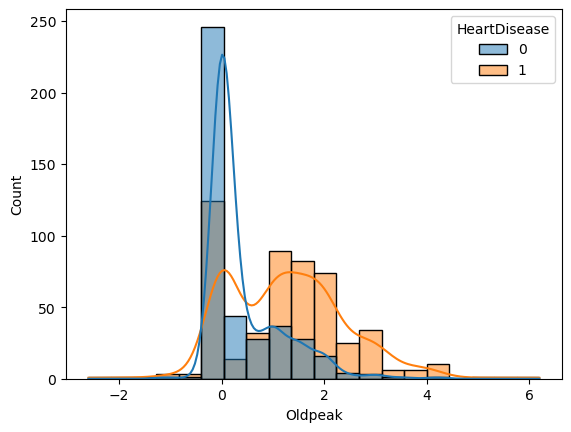

In [37]:
sns.histplot(data=df, x=df['Oldpeak'], bins=20, kde=True, hue='HeartDisease')

Oldpeak = ST depression caused by activity in comparison to rest

<Axes: xlabel='ST_Slope', ylabel='count'>

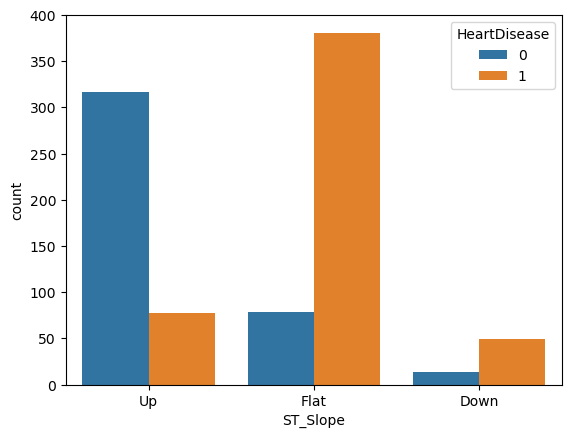

In [38]:
sns.countplot(data=df, x=df['ST_Slope'], hue='HeartDisease')

## Correlations

Text(0.5, 1.0, 'Correlation Heatmap')

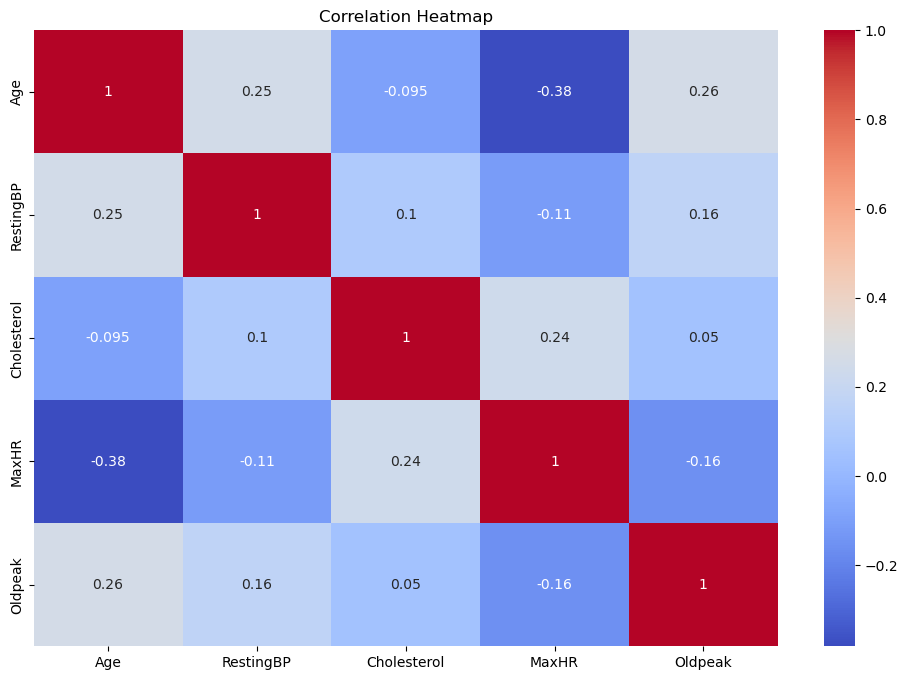

In [62]:
plt.figure(figsize=(12,8))
sns.heatmap(df.drop(['HeartDisease', 'FastingBS'], axis=1).corr(numeric_only=True), cmap='coolwarm', annot=True)
plt.title("Correlation Heatmap")

<Axes: xlabel='Age', ylabel='RestingBP'>

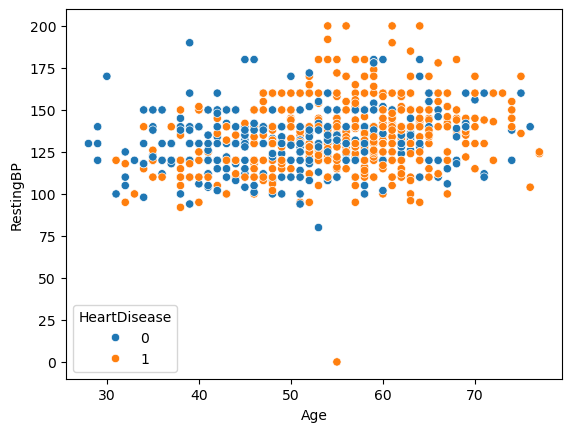

In [40]:
sns.scatterplot(data=df, x='Age', y='RestingBP', hue='HeartDisease')

<Axes: xlabel='Age', ylabel='Oldpeak'>

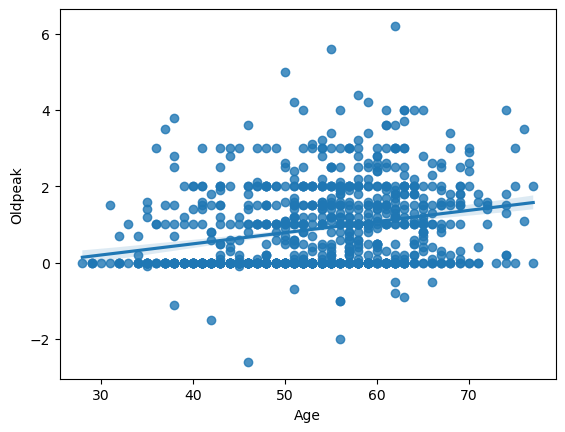

In [41]:
sns.regplot(data=df, x='Age', y='Oldpeak', scatter_kws={})

## Odds Ratios

In [45]:
def get_odds_and_interval(exogeneous, endogeneous):
    y = endogeneous # Dependent Variable
    if exogeneous.dtype == 'object':
        print('Variables')
        for x in exogeneous.unique():
            print(x)
        X = pd.get_dummies(exogeneous, drop_first=True, dtype=int) # Independent variable
        X = sm.add_constant(X)
        result = sm.Logit(y, X).fit()
        print(result.summary())
        print(np.exp(result.params))
        print(np.exp(result.conf_int()))
        print()
    else:
        X = exogeneous
        X = sm.add_constant(X)
        result = sm.Logit(y, X).fit()
        print(result.summary())
        print(np.exp(result.params))
        print(np.exp(result.conf_int()))
        print()

In [46]:
for col in df.columns[:-1]:
    print(f'{col}: Odds Ratio and Confidence Interval')
    get_odds_and_interval(df[col], df['HeartDisease'])

Age: Odds Ratio and Confidence Interval
Optimization terminated successfully.
         Current function value: 0.646372
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:           HeartDisease   No. Observations:                  918
Model:                          Logit   Df Residuals:                      916
Method:                           MLE   Df Model:                            1
Date:                Sat, 01 Mar 2025   Pseudo R-squ.:                 0.05974
Time:                        18:37:04   Log-Likelihood:                -593.37
converged:                       True   LL-Null:                       -631.07
Covariance Type:            nonrobust   LLR p-value:                 3.850e-18
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.2131      0.420     -7.650      0.000      -4.036  

In [47]:
X = pd.get_dummies(df['ST_Slope'], drop_first=False, dtype=int).drop('Flat', axis=1)
X = sm.add_constant(X)
result = sm.Logit(df['HeartDisease'], X).fit()
print(result.summary())
print(np.exp(result.params))  # Odds Ratios
print(np.exp(result.conf_int()))  # Confidence Intervals

Optimization terminated successfully.
         Current function value: 0.479965
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:           HeartDisease   No. Observations:                  918
Model:                          Logit   Df Residuals:                      915
Method:                           MLE   Df Model:                            2
Date:                Sat, 01 Mar 2025   Pseudo R-squ.:                  0.3018
Time:                        18:37:04   Log-Likelihood:                -440.61
converged:                       True   LL-Null:                       -631.07
Covariance Type:            nonrobust   LLR p-value:                 1.923e-83
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5734      0.124     12.727      0.000       1.331       1.816
Down          -0.3206      0.

In [48]:
X = pd.get_dummies(df['ChestPainType'], drop_first=False, dtype=int).drop('ATA', axis=1)
X = sm.add_constant(X)
result = sm.Logit(df['HeartDisease'], X).fit()
print(result.summary())
print(np.exp(result.params))  # Odds Ratios
print(np.exp(result.conf_int()))  # Confidence Intervals

Optimization terminated successfully.
         Current function value: 0.531450
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           HeartDisease   No. Observations:                  918
Model:                          Logit   Df Residuals:                      914
Method:                           MLE   Df Model:                            3
Date:                Sat, 01 Mar 2025   Pseudo R-squ.:                  0.2269
Time:                        18:37:04   Log-Likelihood:                -487.87
converged:                       True   LL-Null:                       -631.07
Covariance Type:            nonrobust   LLR p-value:                 8.752e-62
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8259      0.220     -8.301      0.000      -2.257      -1.395
ASY            3.1528      0.

### Odds Ratios of Note From Binary Variables:
- Male: 4.905918
- Fasting BS (> 120 mg/dl): 4.183701
- Exercise Angina = Y: 10.623106

*There were many other significant odds ratios. These were just a few that were especially high*

## More exploration among the variables with the highest odds ratios

In [49]:
df['ChestPainType']

0      ATA
1      NAP
2      ATA
3      ASY
4      NAP
      ... 
913     TA
914    ASY
915    ASY
916    ATA
917    NAP
Name: ChestPainType, Length: 918, dtype: object

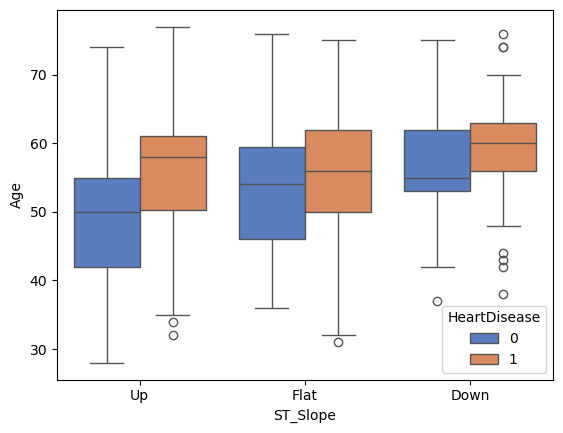

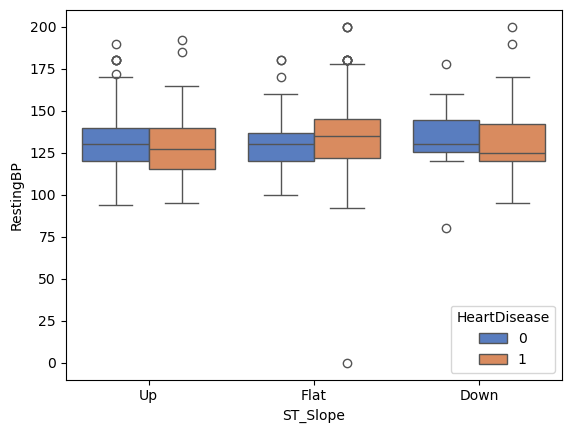

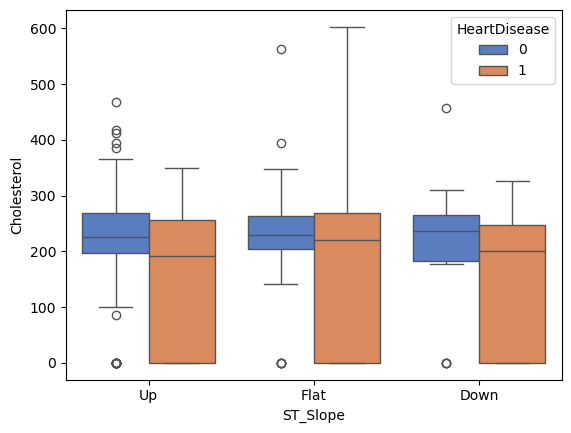

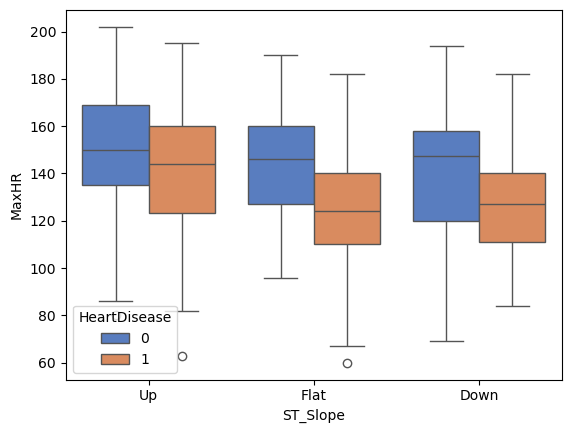

In [50]:
sns.boxplot(data=df, x='ST_Slope', y='Age', hue='HeartDisease', palette='muted')
plt.show()
sns.boxplot(data=df, x='ST_Slope', y='RestingBP', hue='HeartDisease', palette='muted')
plt.show()
sns.boxplot(data=df, x='ST_Slope', y='Cholesterol', hue='HeartDisease', palette='muted')
plt.show()
sns.boxplot(data=df, x='ST_Slope', y='MaxHR', hue='HeartDisease', palette='muted')
plt.show()

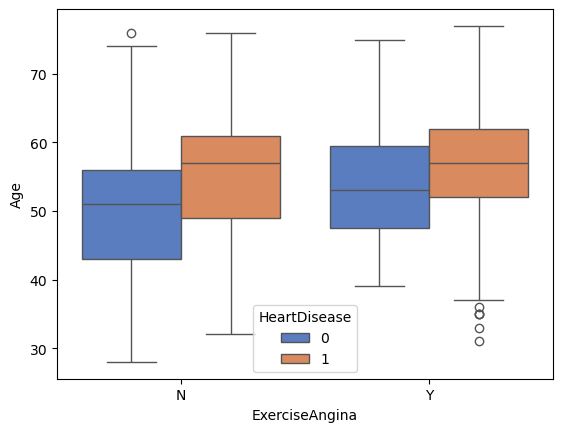

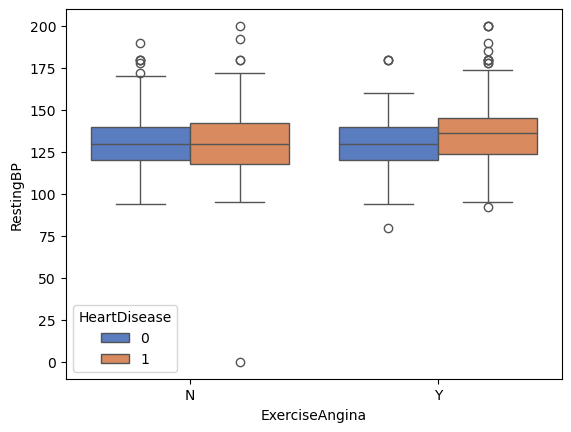

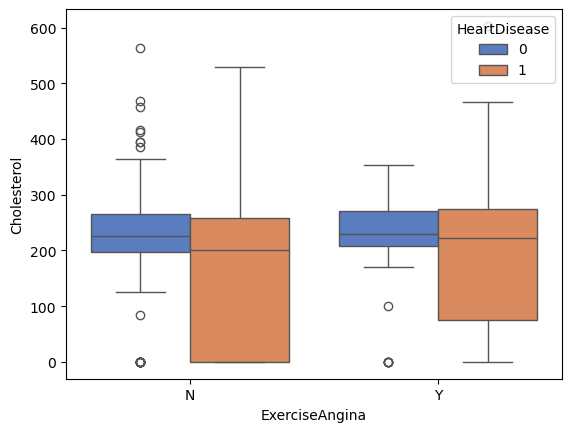

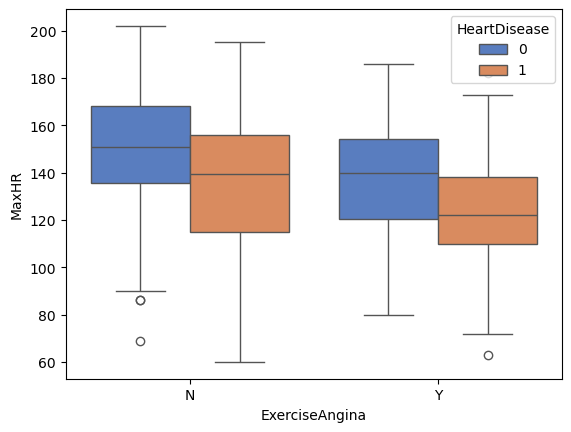

In [51]:
sns.boxplot(data=df, x='ExerciseAngina', y='Age', hue='HeartDisease', palette='muted')
plt.show()
sns.boxplot(data=df, x='ExerciseAngina', y='RestingBP', hue='HeartDisease', palette='muted')
plt.show()
sns.boxplot(data=df, x='ExerciseAngina', y='Cholesterol', hue='HeartDisease', palette='muted')
plt.show()
sns.boxplot(data=df, x='ExerciseAngina', y='MaxHR', hue='HeartDisease', palette='muted')
plt.show()

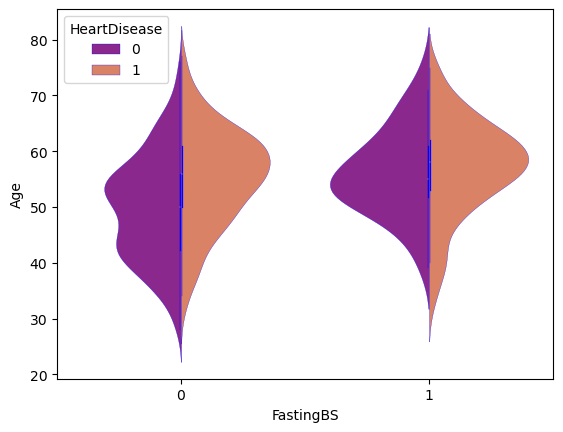

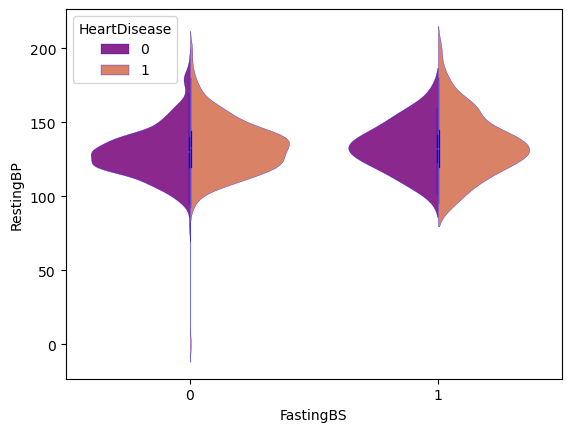

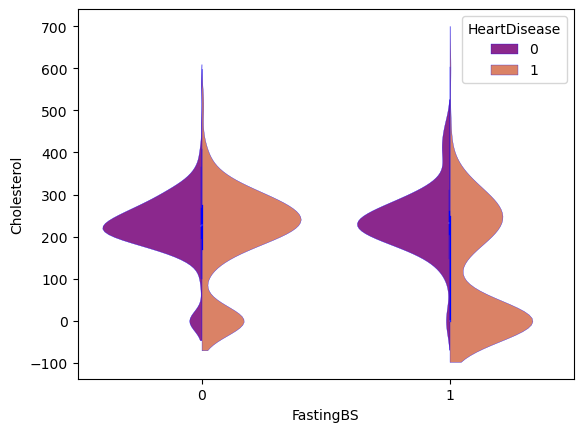

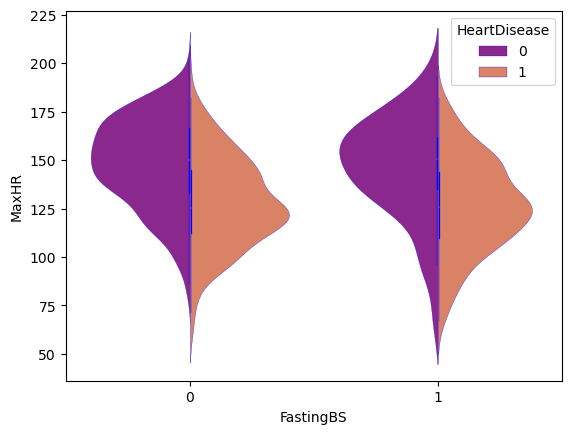

In [52]:
sns.violinplot(data=df, x='FastingBS', y='Age', hue='HeartDisease', palette='plasma', edgecolor='b', linewidth=.2, split=True)
plt.show()
sns.violinplot(data=df, x='FastingBS', y='RestingBP', hue='HeartDisease', palette='plasma', edgecolor='b', linewidth=.2, split=True)
plt.show()
sns.violinplot(data=df, x='FastingBS', y='Cholesterol', hue='HeartDisease', palette='plasma', edgecolor='b', linewidth=.2, split=True)
plt.show()
sns.violinplot(data=df, x='FastingBS', y='MaxHR', hue='HeartDisease', palette='plasma', edgecolor='b', linewidth=.2, split=True)
plt.show()

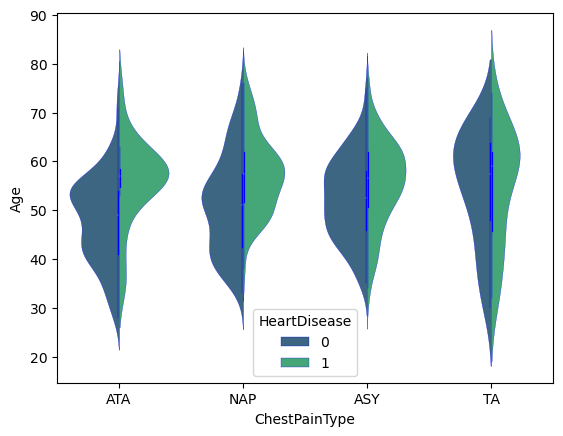

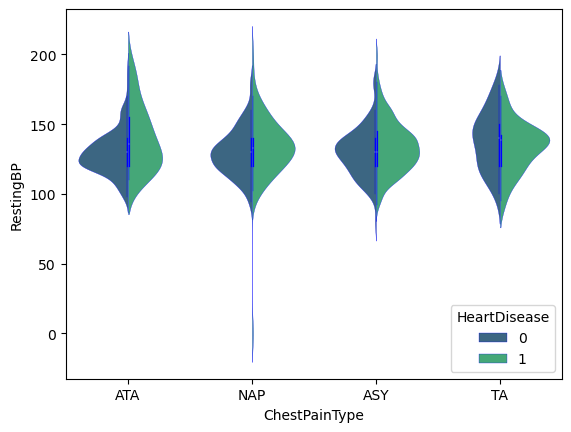

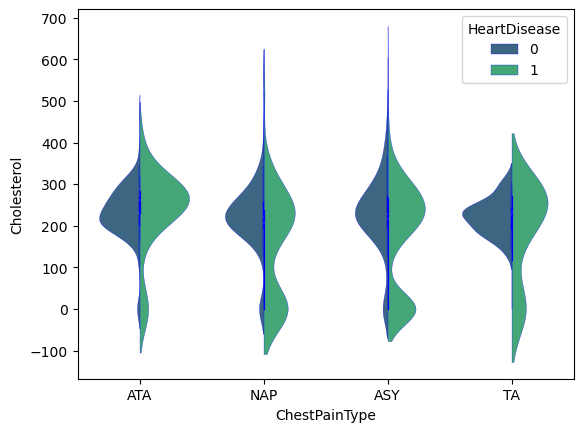

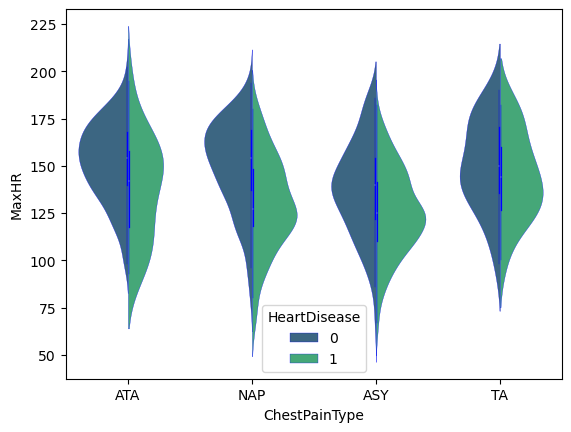

In [53]:
sns.violinplot(data=df, x='ChestPainType', y='Age', hue='HeartDisease', palette='viridis', edgecolor='b', linewidth=.2, split=True)
plt.show()
sns.violinplot(data=df, x='ChestPainType', y='RestingBP', hue='HeartDisease', palette='viridis', edgecolor='b', linewidth=.2, split=True)
plt.show()
sns.violinplot(data=df, x='ChestPainType', y='Cholesterol', hue='HeartDisease', palette='viridis', edgecolor='b', linewidth=.2, split=True)
plt.show()
sns.violinplot(data=df, x='ChestPainType', y='MaxHR', hue='HeartDisease', palette='viridis', edgecolor='b', linewidth=.2, split=True)
plt.show()

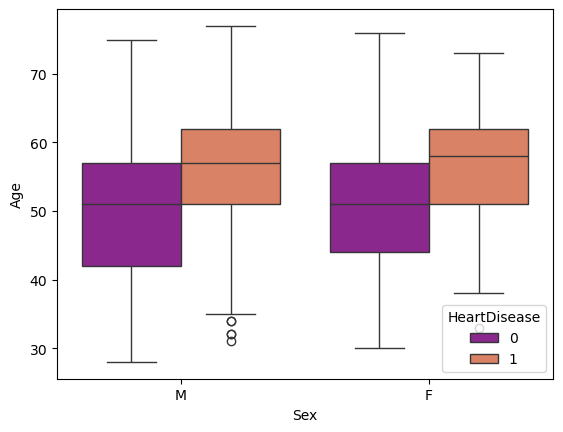

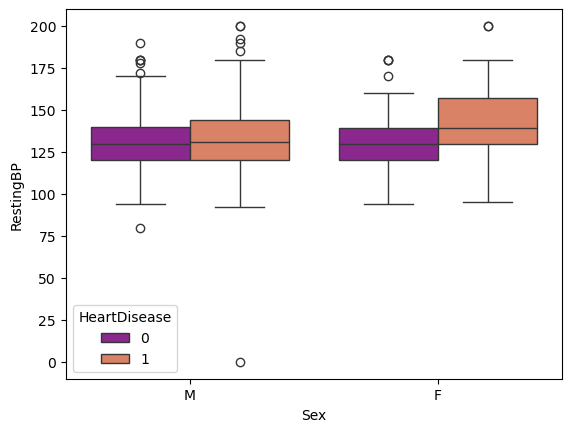

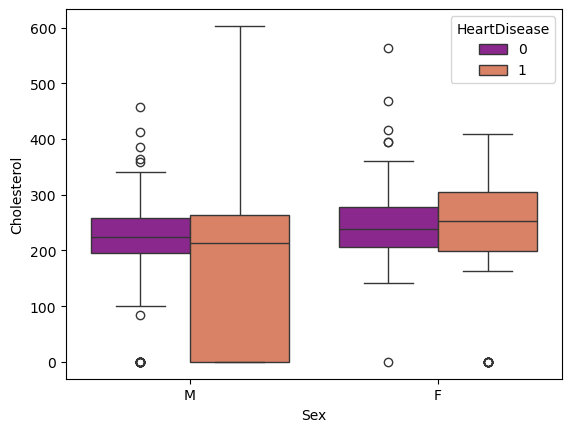

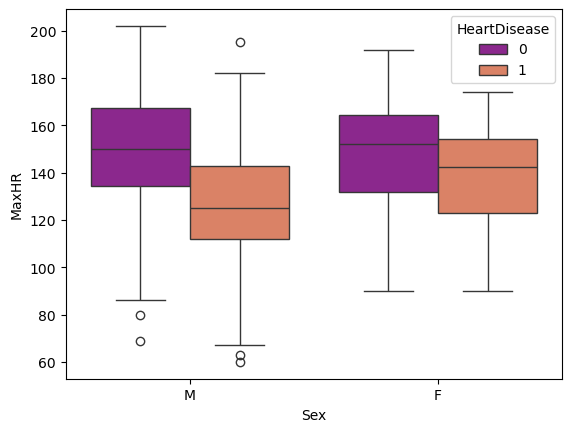

In [54]:
sns.boxplot(data=df, x='Sex', y='Age', hue='HeartDisease', palette='plasma')
plt.show()
sns.boxplot(data=df, x='Sex', y='RestingBP', hue='HeartDisease', palette='plasma')
plt.show()
sns.boxplot(data=df, x='Sex', y='Cholesterol', hue='HeartDisease', palette='plasma')
plt.show()
sns.boxplot(data=df, x='Sex', y='MaxHR', hue='HeartDisease', palette='plasma')
plt.show()

# List 3 observations:


### 1. The most significant (binary) odds ratio is Excercise Angina
- Patients who have Exercise Angina are 10.6 times more likely to have Heart Disease than when thay do not have Exercise Angina, assuming all other variables are constant.
### 2. The strongest three correlations are
- A moderate-negative correlation bewtween MaxHR and Age (as Age goes down, MaxHR goes up and vice versa)
- A weak-positive correlation between Age and Oldpeak
- A weak-positive correlation between Age and RestingBP
### 3. Among these categorical variables, the following show a stronger association with heart disease based on the graphs
- Sex: Higher prevalence in males
- Chest Pain Type: Strongest association with ASY (Asymptomatic)
- Fasting Blood Sugar: Increased risk when above 120 mg/dL
- Resting ECG: Stronger association with ST
- Exercise Angina: More common in those with Exercise Angina
- ST Slope: Strongest correlation with Flat ST Slope 

# Modeling

# 1. Identify Features and Target Variables 
1. Identify Features and Target Variable
Assume "HeartDisease" is the binary target variable.

In [56]:
# Features
X = df.drop('HeartDisease', axis=1)
# Target Variable
y = df['HeartDisease']

#  2. Identify Categorical and Continuous Variables

In [57]:
categorical_variables = []
continuous_variables = []
other = []

for col in X.columns:
    if X[col].dtype == 'object':
        categorical_variables.append(col)
    if X[col].dtype == 'int':
        continuous_variables.append(col)
    else:
        other.append(col)

In [58]:
categorical_variables

['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

In [ ]:
continuous_variables.remove('FastingBS')

In [65]:
continuous_variables

['Age', 'RestingBP', 'Cholesterol', 'MaxHR']

## Missing Values

<Axes: >

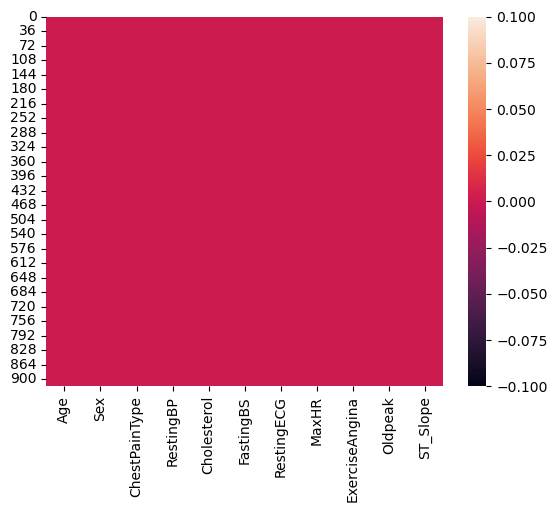

In [ ]:
sns.heatmap(X.isnull())

No missing values to handle

# Step 4: Split the Data into Training and Testing Sets

test_size=0.2: 20% of the data is used for testing.
stratify=y: Ensures that the proportion of classes is maintained in both train and test sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# Resetting the indexes to avoid future merging issues
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Step 5.1: Standardize Continuous Variables
Classification works best when numerical features are standardized. Use standard scalar

In [ ]:
X_train

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,63,M,ATA,139,217,1,ST,128,Y,1.2,Flat
1,55,M,ATA,110,214,1,ST,180,N,0.4,Up
2,59,F,ASY,130,338,1,ST,130,Y,1.5,Flat
3,47,M,ASY,160,0,0,Normal,124,Y,0.0,Flat
4,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat
...,...,...,...,...,...,...,...,...,...,...,...
729,51,M,NAP,135,160,0,Normal,150,N,2.0,Flat
730,46,M,NAP,120,230,0,Normal,150,N,0.0,Up
731,59,M,ASY,122,233,0,Normal,117,Y,1.3,Down
732,61,M,ASY,125,292,0,ST,115,Y,0.0,Up


In [ ]:
train_scaled = pd.DataFrame(StandardScaler().fit_transform(X_train[continuous_variables]), columns=continuous_variables)
test_scaled = pd.DataFrame(StandardScaler().fit_transform(X_test[continuous_variables]), columns=continuous_variables)

In [ ]:
train_scaled

,Age,RestingBP,Cholesterol,FastingBS,MaxHR
0,0.970012,0.339016,0.127137,1.835497,-0.324520
1,0.122028,-1.266031,0.099443,1.835497,1.689837
2,0.546020,-0.159102,1.244113,1.835497,-0.247045
3,-0.725956,1.501291,-1.876035,-0.544812,-0.479470
4,-0.407962,0.671094,-1.876035,1.835497,0.101594
...,...,...,...,...,...
729,-0.301964,0.117630,-0.399042,-0.544812,0.527708
730,-0.831954,-0.712567,0.247142,-0.544812,0.527708
731,0.546020,-0.601874,0.274836,-0.544812,-0.750634
732,0.758016,-0.435834,0.819477,-0.544812,-0.828109


In [ ]:
test_scaled

,Age,RestingBP,Cholesterol,FastingBS,MaxHR
0,-0.664177,-0.773040,-1.624899,-0.577350,-1.070844
1,0.629036,0.075405,0.384517,-0.577350,1.445571
2,0.844571,-0.273955,0.689518,-0.577350,0.103483
3,-0.340874,-0.523497,0.061575,-0.577350,0.019603
4,-1.418551,0.374857,0.348635,-0.577350,0.564826
...,...,...,...,...,...
179,-0.771945,0.474674,0.384517,1.732051,-0.693382
180,0.413500,-0.273955,0.608782,1.732051,0.229304
181,-0.340874,-0.024412,-1.624899,-0.577350,0.271244
182,0.736803,-1.022583,0.519076,-0.577350,0.145423


# Step 5.2: One-Hot Encode Categorical Variables 
Use Pandas' built-in get_dummies() method. Set drop_first to True. Use .astype(int) to ensure they are boolean 1 and 0.

In [74]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first').set_output(transform='pandas')

In [ ]:
# Scaled and transformed X_train
X_train = pd.concat([train_scaled, ohe.fit_transform(X_train[categorical_variables])], axis=1)

In [ ]:
# Scaled and transformed X_test
X_test = pd.concat([test_scaled, ohe.fit_transform(X_test[categorical_variables])], axis=1)

### Print the shape of X_train and X_test

In [ ]:
X_train

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,0.970012,0.339016,0.127137,1.835497,-0.324520,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
1,0.122028,-1.266031,0.099443,1.835497,1.689837,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.546020,-0.159102,1.244113,1.835497,-0.247045,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
3,-0.725956,1.501291,-1.876035,-0.544812,-0.479470,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,-0.407962,0.671094,-1.876035,1.835497,0.101594,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,-0.301964,0.117630,-0.399042,-0.544812,0.527708,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
730,-0.831954,-0.712567,0.247142,-0.544812,0.527708,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
731,0.546020,-0.601874,0.274836,-0.544812,-0.750634,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
732,0.758016,-0.435834,0.819477,-0.544812,-0.828109,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0


In [ ]:
X_test

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,-0.664177,-0.773040,-1.624899,-0.577350,-1.070844,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.629036,0.075405,0.384517,-0.577350,1.445571,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.844571,-0.273955,0.689518,-0.577350,0.103483,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,-0.340874,-0.523497,0.061575,-0.577350,0.019603,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-1.418551,0.374857,0.348635,-0.577350,0.564826,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,-0.771945,0.474674,0.384517,1.732051,-0.693382,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
180,0.413500,-0.273955,0.608782,1.732051,0.229304,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
181,-0.340874,-0.024412,-1.624899,-0.577350,0.271244,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
182,0.736803,-1.022583,0.519076,-0.577350,0.145423,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [ ]:
X_train.shape

(734, 14)

In [ ]:
X_test.shape

(184, 14)

# Step 5.4: Train a Random Forest Classifier Model

In [ ]:
# Test out 1-300 estimators for our model to see what hyperparamter to choose for our Random Forest Model

scores =[]
for k in range(1,300):
    rfc = RandomForestClassifier(n_estimators=k, random_state=42)
    rfc.fit(X_train, y_train)
    rfc_pred = rfc.predict(X_test)
    scores.append(accuracy_score(y_test, rfc_pred))

Text(0, 0.5, 'Accuracy')

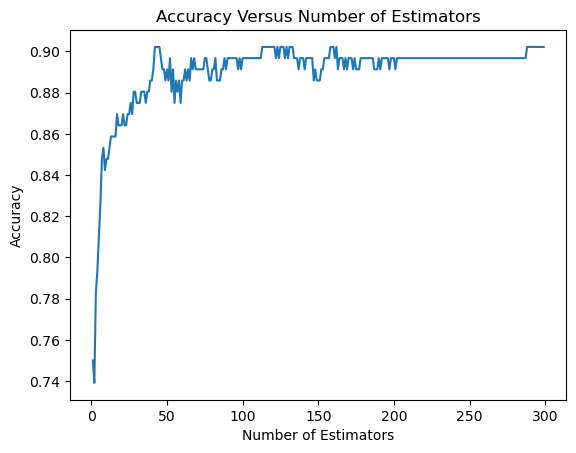

In [ ]:
plt.plot(range(1,300), scores)
plt.title("Accuracy Versus Number of Estimators")
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")

It tapers off pretty quickly, but we will choose to use 150 N_estimators

# Step 6: Make Predictions

In [ ]:
rfc = RandomForestClassifier(n_estimators=125)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
rfc_scores = rfc.predict_proba(X_test)[:, 1] #Probabilities of each sample belonging to the heart_disease=y class

# Step 7: Print Classification Report

In [ ]:
print(confusion_matrix(y_test, rfc_pred))
print(classification_report(y_test, rfc_pred))

[[70 12]
 [ 9 93]]
              precision    recall  f1-score   support

           0       0.89      0.85      0.87        82
           1       0.89      0.91      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184



# Step 8: Create a Formatted Confusion Matrix

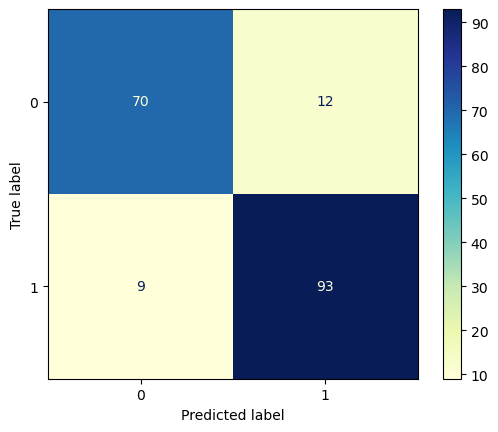

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, rfc_pred))
cm_display.plot(cmap='YlGnBu',)

True Negative (Top-Left Quadrant)

False Positive (Top-Right Quadrant)

False Negative (Bottom-Left Quadrant)

True Positive (Bottom-Right Quadrant)

# Step 9: Print an AUC Curve

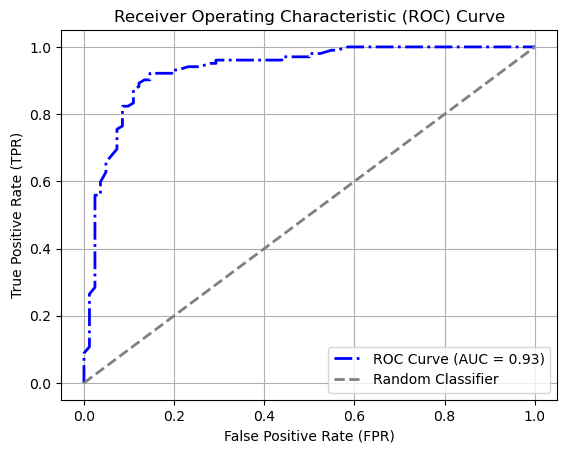

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, rfc_scores)
plt.plot(fpr, tpr, color='blue', linestyle='-.', lw=2, label=f'ROC Curve (AUC = {roc_auc_score(y_test, rfc_scores):.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label="Random Classifier")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)



# Step 10: Print a Precision-Recall Curve

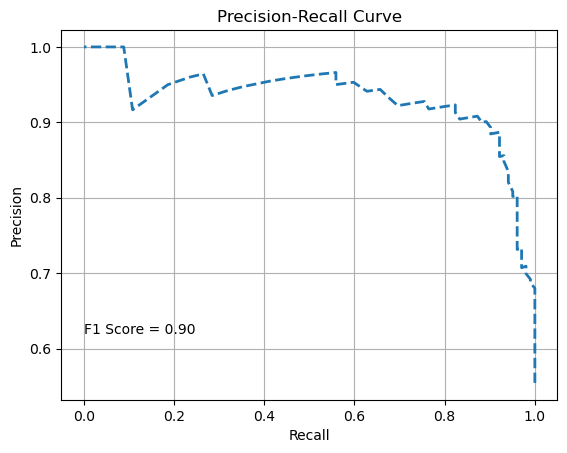

In [ ]:
rfc_f1 = f1_score(y_test, rfc_pred)
precision,recall,_ = precision_recall_curve(y_test, rfc_scores)
plt.plot(recall, precision, lw=2, linestyle='--')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.text(x=0, y=0.62, s=f"F1 Score = {rfc_f1:.2f}")
plt.grid(True)

# Step 11: Compute and plot precision and recall vs threshold

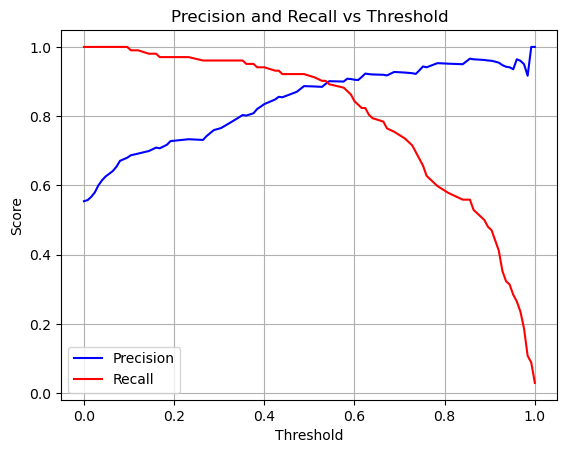

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, rfc_scores)

# Plot precision and recall vs threshold
plt.plot(thresholds, precision[:-1], label="Precision", color="blue")
plt.plot(thresholds, recall[:-1], label="Recall", color="red")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.legend()
plt.grid(True)

In [ ]:
# Manually Setting the Threshold of the predictions to increase recall at the expense of precision
threshold = 0.4
manual_predict = (rfc_scores>=threshold).astype(int)

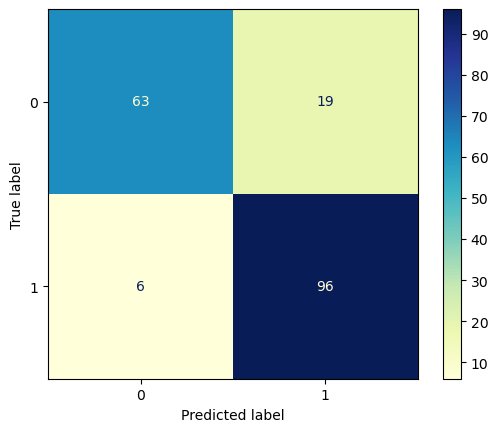

In [ ]:
cm_display2 = ConfusionMatrixDisplay(confusion_matrix(y_test, manual_predict))
cm_display2.plot(cmap='YlGnBu')

With the manual predictions there are less false negatives

# Step 12: use model.features_importances_ to show the top 10 most important features

In [ ]:
features = pd.DataFrame({'Variables': X_train.columns, 'Importance': rfc.feature_importances_})
top_10 = features.sort_values(by='Importance', ascending=False).head(10)

Text(0.5, 1.0, 'Feature Importance')

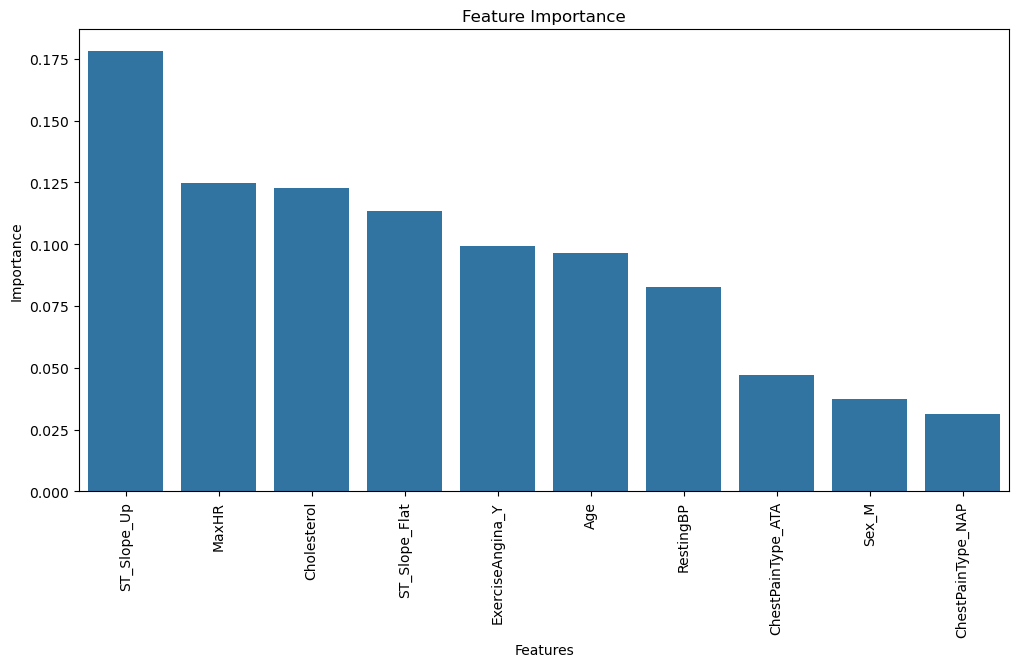

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(x=top_10['Variables'], y=top_10['Importance'])
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance")

ST_Slope_Up has the highest feature importance, meaning it does the best job of reducing Gini impurity and splitting the data compared to the other features.

# Repeat Steps 5.4 through 12 for logistic regression, K-nearest neighbors, and xgboost models

In [83]:
# Pipeline

def model_build_eval(model):
    # Training the Model and predicting
    md = model
    md.fit(X_train, y_train)
    pred = md.predict(X_test)
    y_score = md.predict_proba(X_test)[:,1] # Probabilities of each data being classified as the positive class
    
    print("Classification Report")
    print(classification_report(y_test, pred))
    
    cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, pred))
    cm_display.plot(cmap='YlGnBu')
    plt.title("Confusion Matrix")
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_score)
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC={roc_auc_score(y_test, y_score):.2f})')
    plt.plot([0,1], [0,1], color='gray', linestyle='--', lw=2, label="Random Classifier")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Reciever Operator Characteristic (ROC) Curve")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    
    # Precision and Recall Curve
    f1 = f1_score(y_test, pred)
    precision,recall,_ = precision_recall_curve(y_test, y_score)
    plt.plot(recall, precision, lw=2, linestyle='--')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.text(x=0, y=0.62, s=f"F1 Score = {f1:.2f}")
    plt.grid(True)
    plt.show()
    
    # Plot precision and recall vs threshold
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    plt.plot(thresholds, precision[:-1], label="Precision", color="blue")
    plt.plot(thresholds, recall[:-1], label="Recall", color="red")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Precision and Recall vs Threshold")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return md

## Logistic Regression

## Fit the Model and Predict

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.84      0.86        82
           1       0.88      0.91      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



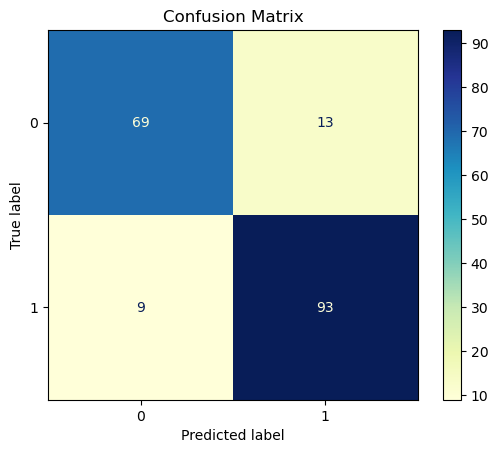

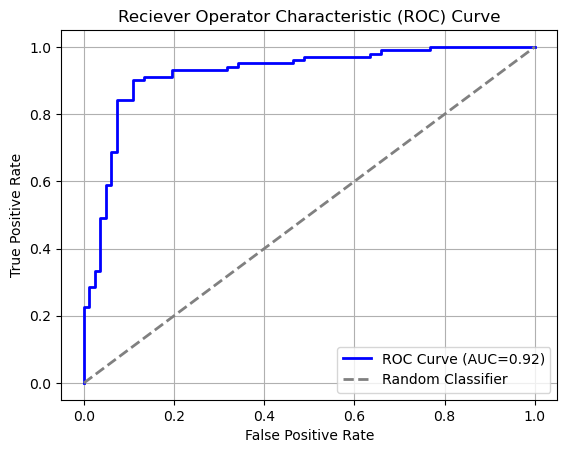

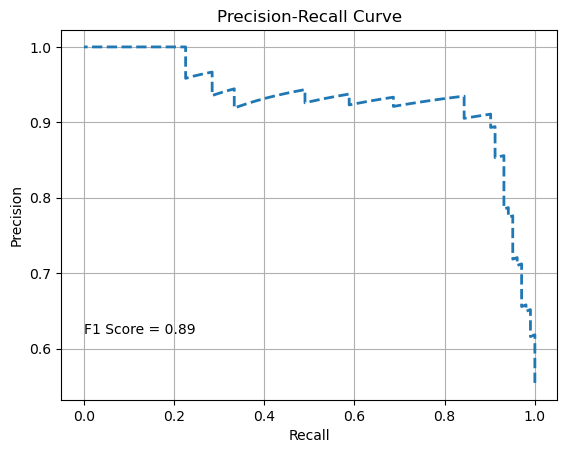

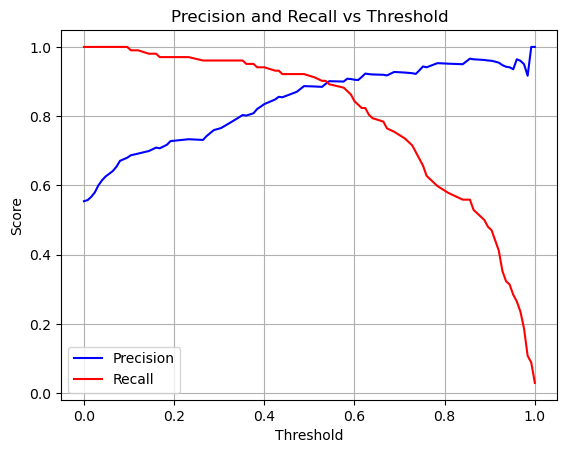

In [ ]:
lr = model_build_eval(LogisticRegression(random_state=42))

In [ ]:
lr.coef_[0]

array([ 0.06638244,  0.04617975, -0.47271703,  0.42096543, -0.16868389,
        1.09467111, -1.53239511, -1.70387495, -1.10991711, -0.36287077,
       -0.35478257,  1.01392179,  0.78730462, -1.73875347])

In [ ]:
lr_features = pd.DataFrame({
    'Features': X_train.columns,
    'Importance': lr.coef_[0]
}).sort_values(by='Importance', ascending=False).head(10)

In [ ]:
lr_features

,Features,Importance
5,Sex_M,1.094671
11,ExerciseAngina_Y,1.013922
12,ST_Slope_Flat,0.787305
3,FastingBS,0.420965
0,Age,0.066382
1,RestingBP,0.046180
4,MaxHR,-0.168684
10,RestingECG_ST,-0.354783
9,RestingECG_Normal,-0.362871
2,Cholesterol,-0.472717


Text(0.5, 1.0, 'Feature Importance')

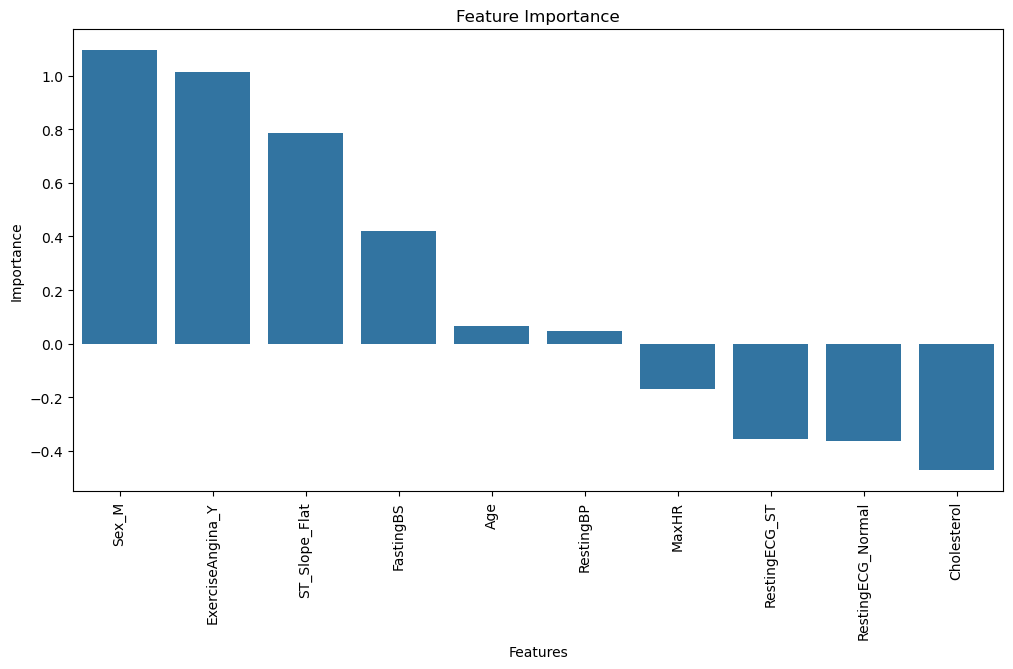

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(x=lr_features['Features'], y=lr_features['Importance'])
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance")

## K Nearest Neighbors

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

              precision    recall  f1-score   support

           0       0.85      0.83      0.84        82
           1       0.87      0.88      0.87       102

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



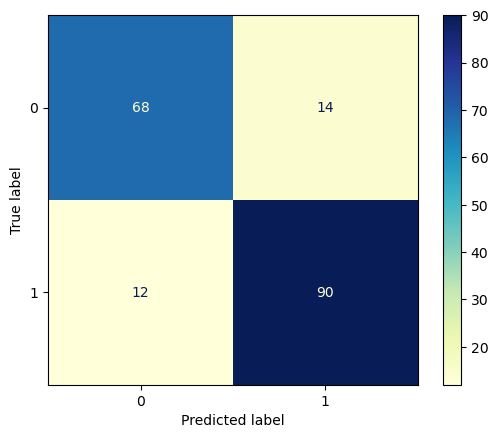

In [ ]:
knn_cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, knn_pred))
knn_cm_display.plot(cmap='YlGnBu')
print(classification_report(y_test, knn_pred))

In [ ]:
# Using the elbow method to decide on the best k-value
error_rate = []
for k in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    error_rate.append(np.mean(pred!=y_test))

Text(0.5, 1.0, 'K Value versus Error Rate')

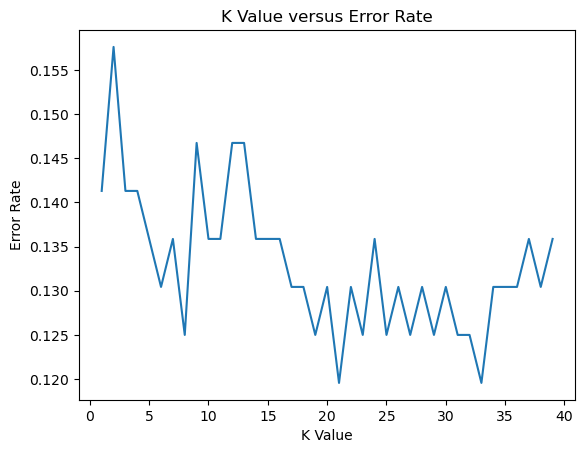

In [ ]:
plt.plot(range(1, 40), error_rate)
plt.xlabel("K Value")
plt.ylabel("Error Rate")
plt.title("K Value versus Error Rate")

Based on the Error Rate Versus K-Value Graph, I will choose a K value of 21

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.84      0.86        82
           1       0.88      0.91      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



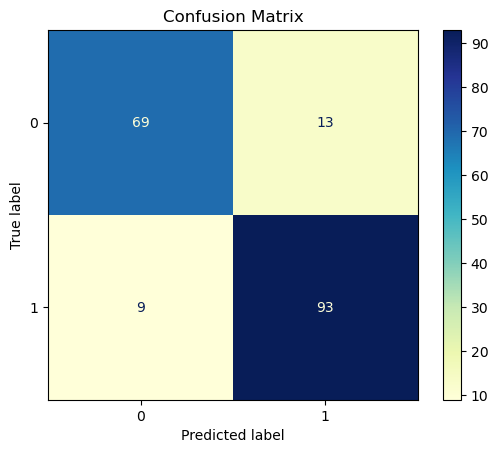

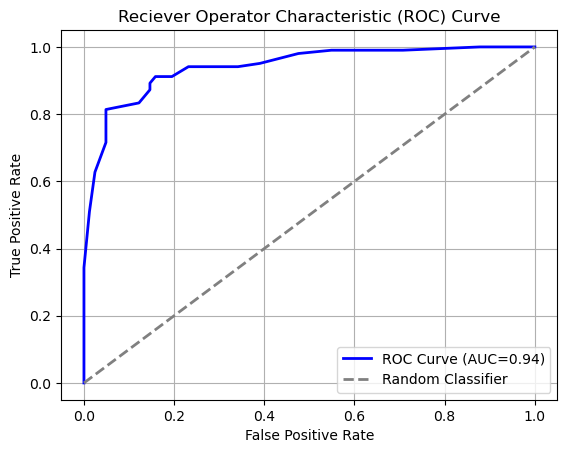

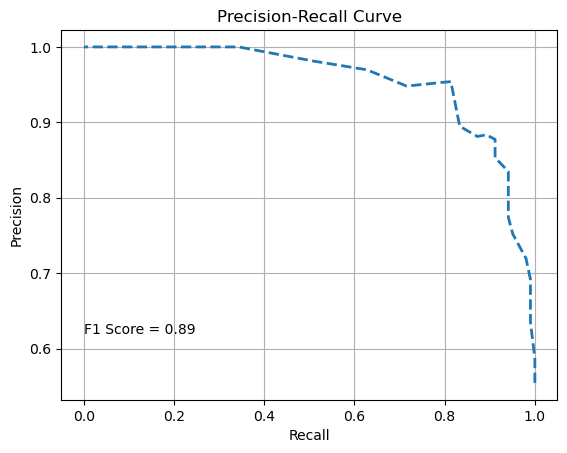

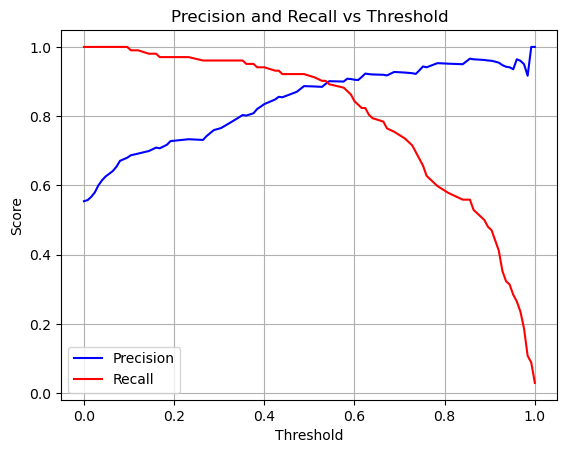

In [ ]:
knn = model_build_eval(KNeighborsClassifier(n_neighbors=21))

In [ ]:
knn_y_score = knn.predict_proba(X_test)[:, 1]

In [ ]:
# Manually Selecting a Threshold for a higher recall rate
threshold=0.4
knn_manual_predict = (knn_y_score >= threshold).astype(int)

              precision    recall  f1-score   support

           0       0.91      0.77      0.83        82
           1       0.83      0.94      0.88       102

    accuracy                           0.86       184
   macro avg       0.87      0.85      0.86       184
weighted avg       0.87      0.86      0.86       184



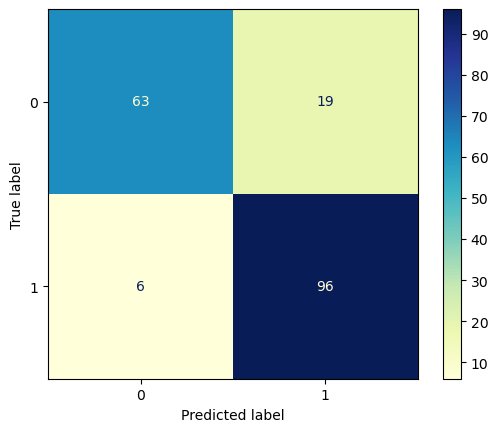

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, knn_manual_predict))
cm_display.plot(cmap='YlGnBu')
print(classification_report(y_test, knn_manual_predict))

With a threshold of 0.4, Sensitivty in predicting positve cases increases from 0.91  to 0.94 whereas precision decreases from 0.88 to 0.83

KNN Feature Importance Technique (from sklearn): Permutation feature importance is a model inspection technique that measures the contribution of each feature to a fitted model’s statistical performance on a given tabular dataset. This technique is particularly useful for non-linear or opaque estimators, and involves randomly shuffling the values of a single feature and observing the resulting degradation of the model’s score. By breaking the relationship between the feature and the target, we determine how much the model relies on such particular feature.

In [ ]:
perm_importance = permutation_importance(knn, X_test, y_test, n_repeats=30, random_state=42, scoring='accuracy')

In [ ]:
knn_features = pd.DataFrame({
    'Features': X_train.columns,
    'Importance': perm_importance['importances_mean']
    }).sort_values(by='Importance', ascending=False).head(10)

Text(0.5, 1.0, 'KNN Feature Importance')

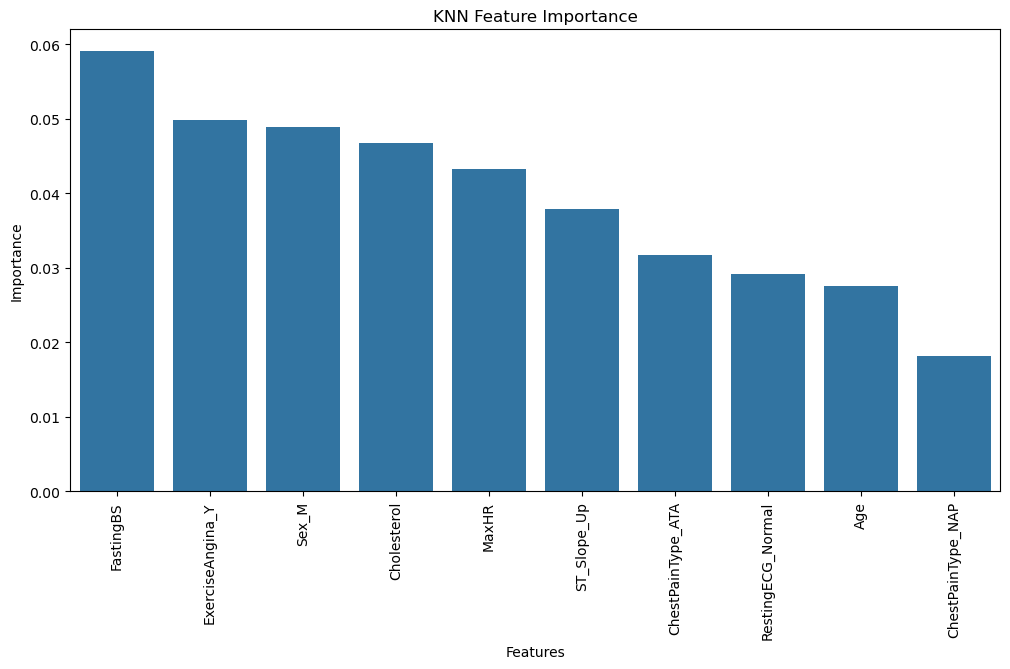

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(x=knn_features['Features'], y=knn_features['Importance'])
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("KNN Feature Importance")

## XG Boost

In [ ]:
# Using Bayes Search to find a Bayesian Optimization for hyperparameter tuning
# Most of these values came from Lianna and Justin YouTube Video on How to Train XGBoost Models in Python


xgb = XGBClassifier(random_state=42)

search_space = {
    'max_depth': Integer(2,8),
    'learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'subsample': Real(0.5, 1.0),
    'col_sample_bytree': Real(0.5, 1.0),
    'col_sample_bynode': Real(0.5, 1.0),
    'reg_alpha': Real(0.0, 10.0),
    'reg_lambda': Real(0.0, 10.0), 
    'gamma': Real(0.0, 10.0),
    'min_child_weight': Integer(5,20),
    'n_estimators': Integer(50, 300)
}

opt = BayesSearchCV(xgb, search_space, cv=5, n_iter=40, scoring='roc_auc', random_state=42)

[12:24:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1738880294500/work/src/learner.cc:740: 
Parameters: { "col_sample_bynode", "col_sample_bytree" } are not used.

[12:24:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1738880294500/work/src/learner.cc:740: 
Parameters: { "col_sample_bynode", "col_sample_bytree" } are not used.

[12:24:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1738880294500/work/src/learner.cc:740: 
Parameters: { "col_sample_bynode", "col_sample_bytree" } are not used.

[12:24:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1738880294500/work/src/learner.cc:740: 
Parameters: { "col_sample_bynode", "col_sample_bytree" } are not used.

[12:24:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1738880294500/work/src/learner.cc:740: 
Parameters: { "col_sample_bynode", "col_sample_bytree" } are not used.

[12:24:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1738880294500/work/src/lea

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        82
           1       0.86      0.91      0.89       102

    accuracy                           0.87       184
   macro avg       0.87      0.86      0.87       184
weighted avg       0.87      0.87      0.87       184



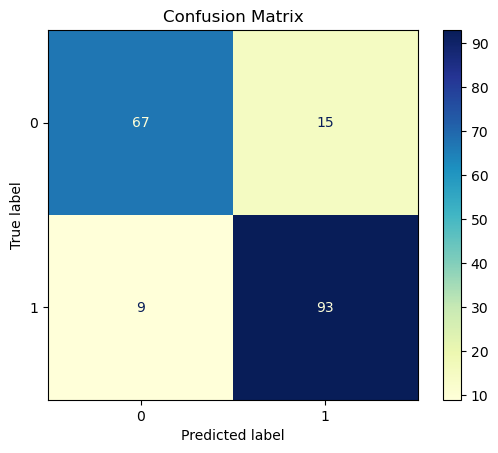

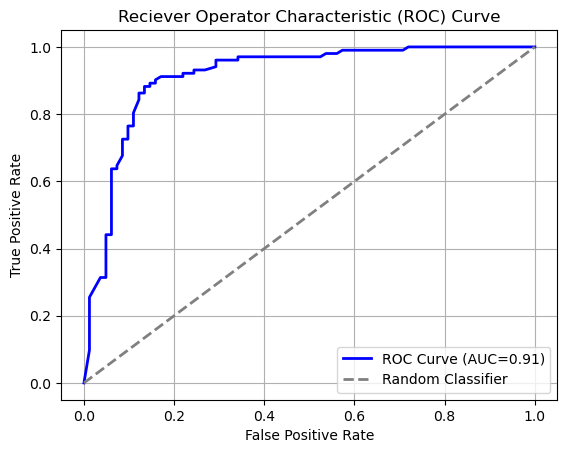

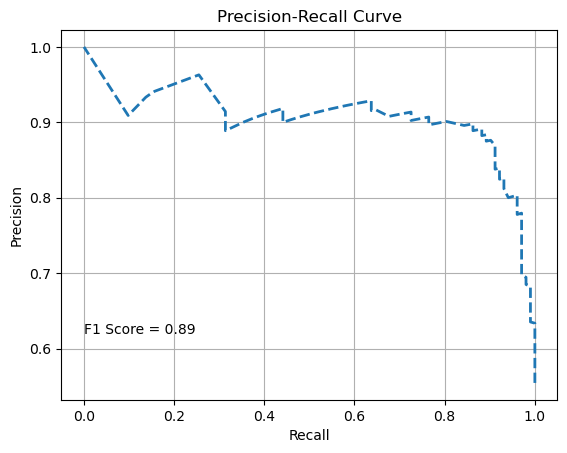

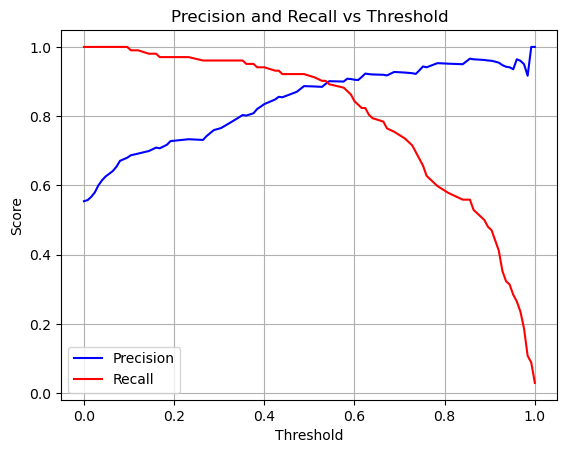

In [ ]:
opt = model_build_eval(BayesSearchCV(xgb, search_space, cv=5, n_iter=40, scoring='roc_auc', random_state=42))

In [ ]:
print(opt.best_estimator_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              col_sample_bynode=0.5, col_sample_bytree=0.7680461780789846,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=4.677143417667992, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.23271542308644855,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=12, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=170, n_jobs=None, ...)


In [ ]:
best_xgb = opt.best_estimator_

In [ ]:
best_xgb.feature_importances_

array([0.03380423, 0.02898091, 0.06189409, 0.03995245, 0.04782039,
       0.04621997, 0.04725943, 0.05631921, 0.        , 0.        ,
       0.        , 0.10283369, 0.04970257, 0.4852131 ], dtype=float32)

In [ ]:
xgb_features = pd.DataFrame({
    'Features': X_train.columns,
    'Importance': best_xgb.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10)

In [ ]:
xgb_features

,Features,Importance
13,ST_Slope_Up,0.485213
11,ExerciseAngina_Y,0.102834
2,Cholesterol,0.061894
7,ChestPainType_NAP,0.056319
12,ST_Slope_Flat,0.049703
4,MaxHR,0.047820
6,ChestPainType_ATA,0.047259
5,Sex_M,0.046220
3,FastingBS,0.039952
0,Age,0.033804


Text(0.5, 1.0, 'XGBoost Feature Importance')

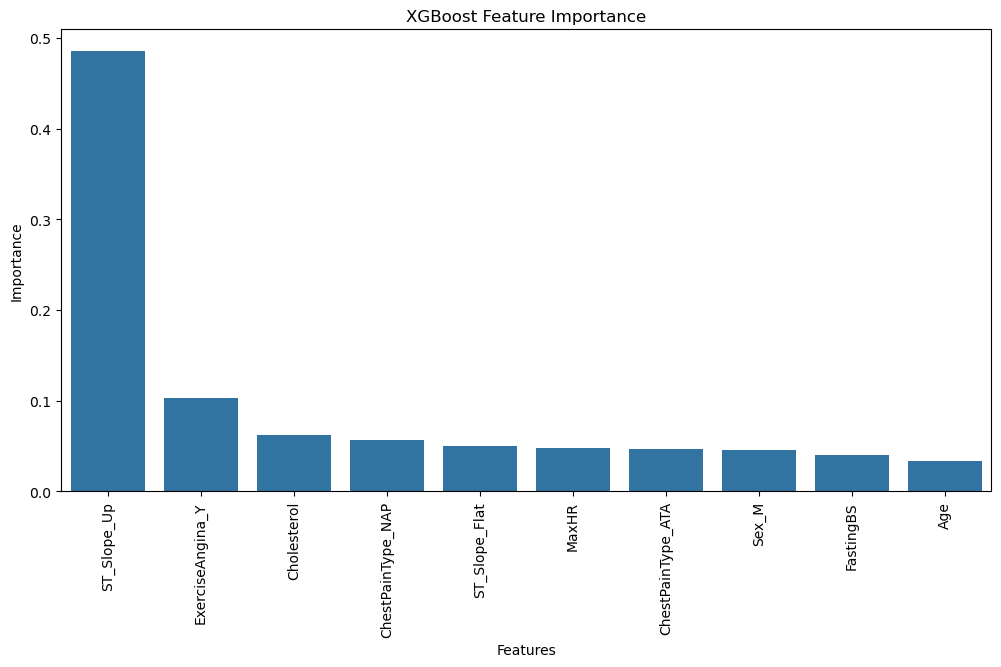

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(x=xgb_features['Features'], y=xgb_features['Importance'])
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("XGBoost Feature Importance")

# Create 5 Powerpoint Slides that Summarize your Analysis and Conclusions